# Prerequisites

The data utilized here comes from the Strava API and the Visual Crossing Weather API. Methods for acquiring the data can be found in `compile_user_laps.py` & `add_weather.py`. Methods utilized in the scripts are derived from the `StravaAPI` class, which is also available to you in the repository. The goal here is to try and identify any trends between weather and running before we try and throw a model at it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

import sklearn.pipeline

os.environ['MKL_DEBUG_CPU_TYPE'] = '5'

strava_palette = {
    'Strava Orange': '#fc4c02',
    'Pumpkin': '#ff7518',
    'Coal': '#262626',
    'Asphalt': '#404040',
    'Gravel': '#757575',
    'Fog': '#d9d9d9',
    'Icicle': '#f0f0f0',
    'Silver': '#c0c0c0'
}

# Set the palette
sns.set_palette(list(strava_palette.values()))

laps_data = pd.read_csv('/Users/bennett/PycharmProjects/CAPi/laps_data.csv')
weather_data = pd.read_csv('/Users/bennett/PycharmProjects/CAPi/weather_data.csv')

running_data = laps_data.merge(weather_data, how='left', on=['name', 'activity_id'])

In [2]:
running_data.head()

,Unnamed: 0_x,id,resource_state,name,elapsed_time,moving_time,start_date,start_date_local,distance,average_speed,...,sealevelpressure,cloudcover,visibility,solarradiation,solarenergy,uvindex,severerisk,conditions,icon,stations
0,0,35896190589,2,Lap 1,404,404,2023-12-21T23:53:34Z,2023-12-21T18:53:34Z,1609.34,3.98,...,1029.2,2.7,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
1,0,35896190589,2,Lap 1,404,404,2023-12-21T23:53:34Z,2023-12-21T18:53:34Z,1609.34,3.98,...,1029.2,2.7,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
2,1,35896190591,2,Lap 2,403,403,2023-12-22T00:00:19Z,2023-12-21T19:00:19Z,1609.34,3.99,...,1029.1,2.4,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
3,1,35896190591,2,Lap 2,403,403,2023-12-22T00:00:19Z,2023-12-21T19:00:19Z,1609.34,3.99,...,1029.1,2.4,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"
4,2,35896190594,2,Lap 3,442,401,2023-12-22T00:07:03Z,2023-12-21T19:07:03Z,1609.34,4.01,...,1029.1,2.4,9.9,0,0.0,0,NaN,Clear,clear-night,"72317013723,KINT,0443W,72319393807,KGSO"


# Data Cleaning & Visualization

We'll remove the unwanted columns here. Furthermore, we need to reduce our dataset to only include non-null values for `start_lat` & `start_long`. This is because if there is no location for the activity lap, then `add_weather.py` won't return any relevant data and we won't be able to utilize the observation in modeling. Another pro to missing `start_lat` & `start_long` is that if they're null, it indicates that they're recorded on a treadmill. This is a huge plus because that weather data would not be valid if it provided these values.

In [3]:
running_data = running_data[['activity_id', 'id', 'name', 'split', 'moving_time', 'distance', 'average_speed', 'average_heartrate', 'average_watts', 'average_cadence', 'max_speed', 'max_heartrate', 'total_elevation_gain', 'pace_zone', 'start_lat', 'start_long', 'datetime', 'temp', 'dew', 'humidity', 'precip', 'snowdepth', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 'visibility', 'conditions']]

running_data.dropna(subset=['start_long', 'start_lat'], inplace=True)
running_data.drop_duplicates(inplace=True)

In [4]:
running_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3939 entries, 0 to 4202
Data columns (total 28 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity_id           3939 non-null   int64  
 1   id                    3939 non-null   int64  
 2   name                  3939 non-null   object 
 3   split                 3939 non-null   int64  
 4   moving_time           3939 non-null   int64  
 5   distance              3939 non-null   float64
 6   average_speed         3939 non-null   float64
 7   average_heartrate     3900 non-null   float64
 8   average_watts         2625 non-null   float64
 9   average_cadence       3897 non-null   float64
 10  max_speed             3939 non-null   float64
 11  max_heartrate         3900 non-null   float64
 12  total_elevation_gain  3939 non-null   float64
 13  pace_zone             3939 non-null   int64  
 14  start_lat             3939 non-null   float64
 15  start_long            3939

In [5]:
running_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
activity_id,3939.0,8.773413e+09,9.405336e+08,3.456349e+09,7.937193e+09,8.799920e+09,9.588534e+09,1.041723e+10
id,3939.0,2.969890e+10,3.524287e+09,1.147277e+10,2.650186e+10,2.985334e+10,3.276485e+10,3.589619e+10
split,3939.0,9.099518e+00,7.892288e+00,1.000000e+00,3.000000e+00,7.000000e+00,1.300000e+01,4.900000e+01
moving_time,3939.0,2.939546e+02,3.246766e+02,1.000000e+00,6.000000e+01,3.750000e+02,4.350000e+02,5.400000e+03
distance,3939.0,1.081291e+03,1.119553e+03,6.510000e+00,2.000000e+02,1.608980e+03,1.609340e+03,1.848640e+04
average_speed,3939.0,3.735392e+00,1.085631e+00,8.900000e-01,3.450000e+00,3.740000e+00,4.250000e+00,9.940000e+00
average_heartrate,3900.0,1.594988e+02,1.261521e+01,0.000000e+00,1.526000e+02,1.603000e+02,1.680000e+02,1.937000e+02
average_watts,2625.0,3.378309e+02,1.111180e+02,0.000000e+00,3.358000e+02,3.589000e+02,4.015000e+02,5.798000e+02
average_cadence,3897.0,8.509015e+01,1.171944e+01,0.000000e+00,8.570000e+01,8.850000e+01,9.090000e+01,1.046000e+02
max_speed,3939.0,4.854017e+00,8.748254e-01,1.206000e+00,4.288000e+00,4.694000e+00,5.284000e+00,1.315600e+01


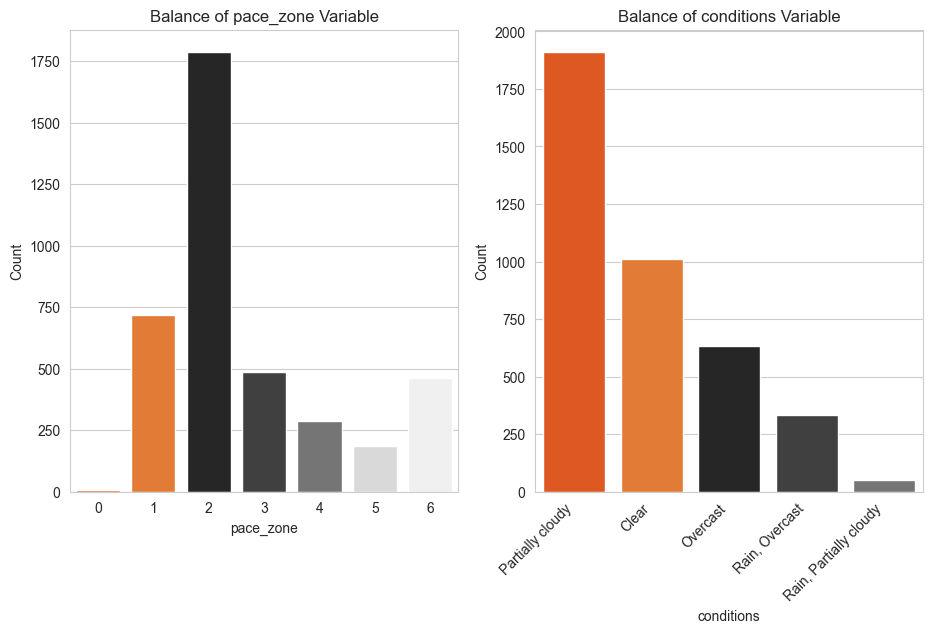

In [6]:
# Overall Figure (2x4 with 8 subplots). Flattening the axes will help seaborn do backend stuff faster.
fig, axes = plt.subplots(1, 2, figsize=(11, 6))
axes = axes.flatten()

# For each of our categorical columns, bar plot it and add it to the appropriate slot in the overall fig
# Enumerate because we need an iterator and the column
for i, column in enumerate(['pace_zone', 'conditions']):
    
    # Create a little mini df from the result of value_counts(), so we can plot it
    values = pd.DataFrame(running_data[column].value_counts().reset_index())
    values.columns = [column, 'Count']
    
    sns.barplot(data=values, x=column, y='Count', ax=axes[i])
    axes[i].set_title(f'Balance of {column} Variable')

axes[1].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
plt.show()

It looks like we can change `conditions` and `pace_zone` to categorical datatypes. Furthermore, `datetime` loaded in as an object. We'll want to update that to the appropriate datatype here as well.

In [7]:
running_data['datetime'] = pd.to_datetime(running_data['datetime'])
running_data['conditions'] = running_data['conditions'].astype('category')
running_data['pace_zone'] = running_data['pace_zone'].astype('category')

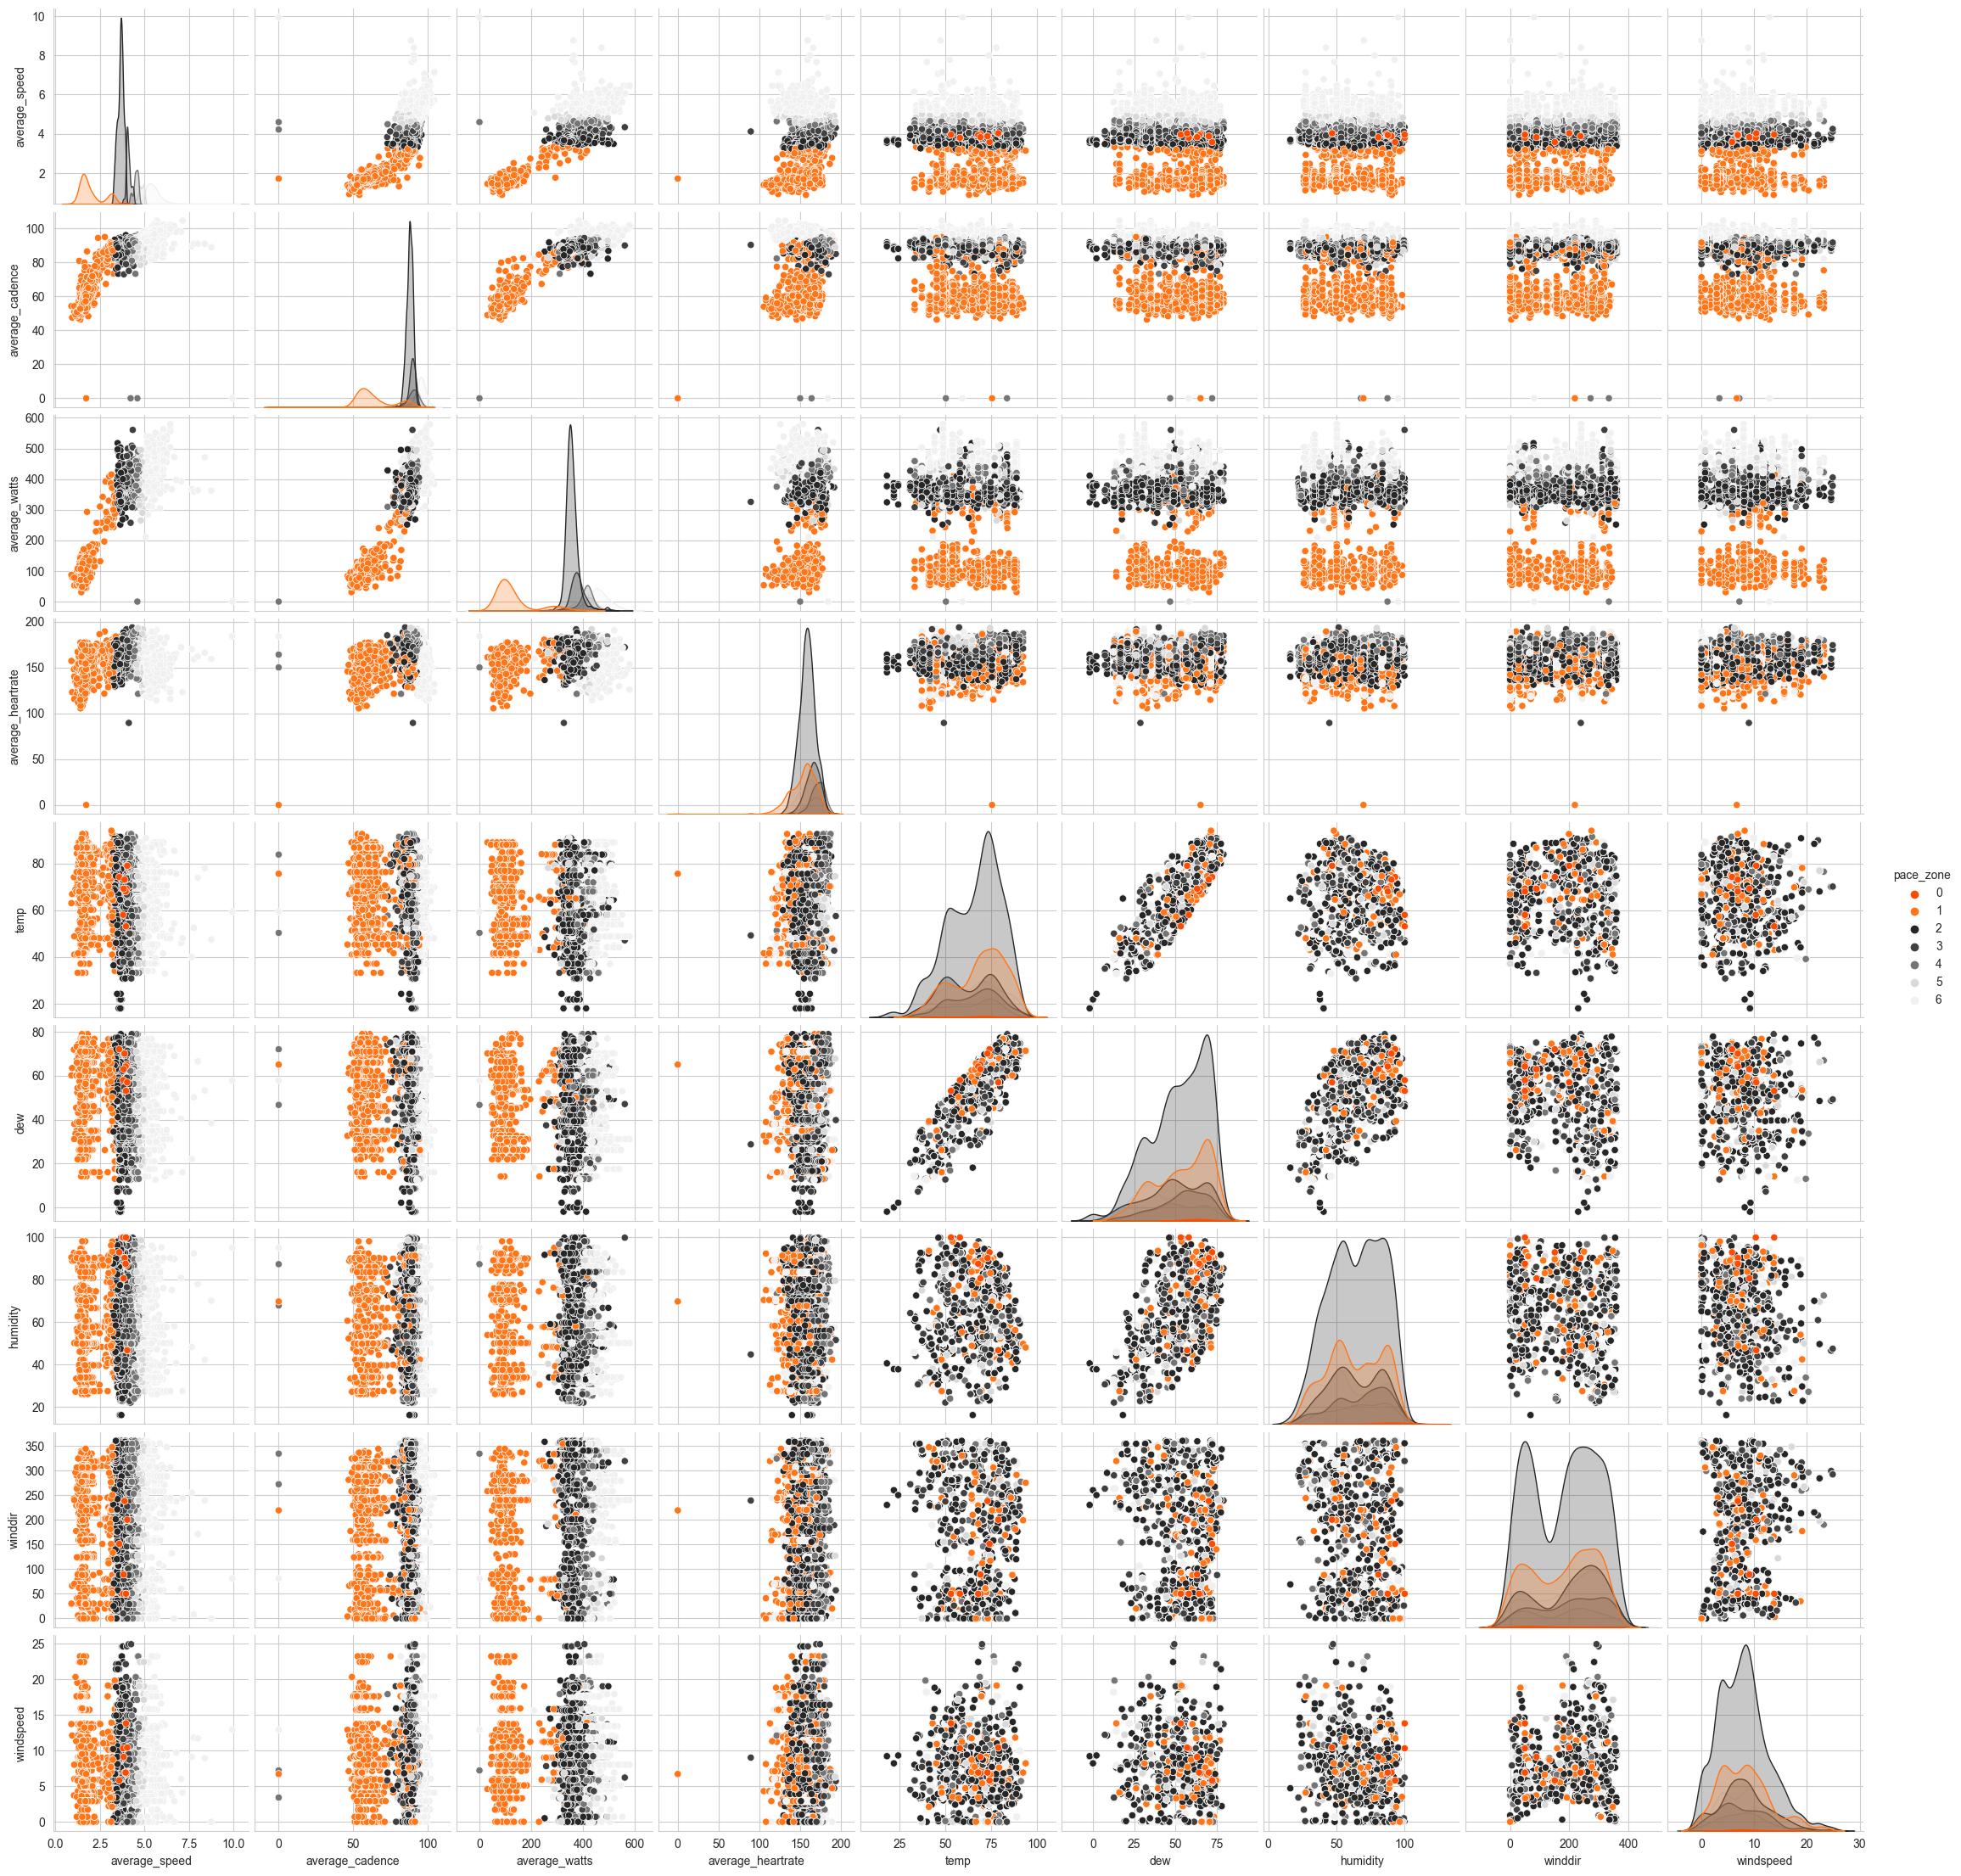

In [8]:
# running info pairplot
sns.pairplot(data=running_data, vars=['average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'temp', 'dew', 'humidity', 'winddir', 'windspeed'], hue='pace_zone');

/Users/bennett/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


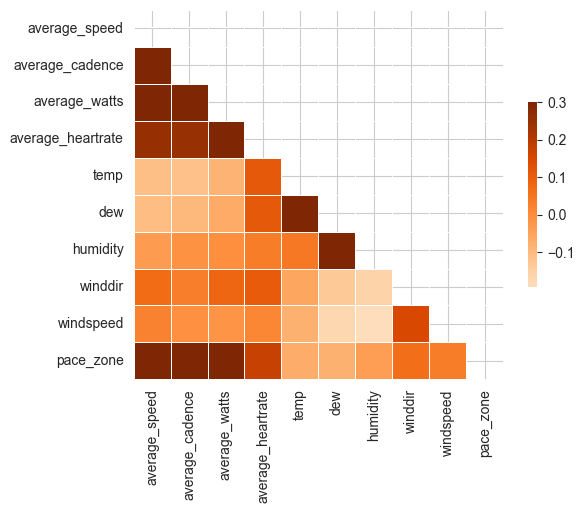

In [9]:
# These parameters for the sns.heatmap are taken from sns.heatmap documentation. It creates a heatmap that very much resembles the corrplot() from R
corr = running_data[['average_speed', 'average_cadence', 'average_watts', 'average_heartrate', 'temp', 'dew', 'humidity', 'winddir', 'windspeed', 'pace_zone']].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr, mask=mask, cmap='Oranges', annot=True,
            vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={'shrink': .5}
            );

We're not really seeing much here. Just like in my research, it's really hard to get a perfect understanding of how the weather is impacting the running variables. This also might partially be due to me being stubborn and trying to hit ranges regardless of the conditions. If this is the case, heartrate should be a good indicator of the relationship.

Lastly, there are a few of my earlier workouts that don't have heartrate information. This is because I was not using a fitness watch earlier on. We should limit the data to after I got my garmin, by filtering out activity laps where any heartrate related data is missing. Furthermore, there are a noticeable amount of missing values in average watts. Since most of the other variables together probably do a good job of conveying power anyways, we can just remove the column to keep our dataset larger. 

In [10]:
running_data.drop(columns=['average_watts'], inplace=True)
running_data.dropna(subset=['average_heartrate'], inplace=True)

running_data.dropna(subset=['average_cadence'], inplace=True)       # 3 instances of missing cadence, removing these shouldn't hurt the overall results

# Feature Engineering

A few things need to be done here.
- I want to keep track of how much distance has elapsed in the given workout (we can just keep summing distance by lap for each activity). I know that the further and longer an activity goes on, there's some level of impact on your internals. We need to account for it
- I also want to make a conversion for distance and time elapsed to get a mile per min pace variable. This will be helpful for post modelling when we want to chart out the CAPi paces.

## Distance Covered Prior and Time Covered Prior

Obviously, a run gets harder the longer it goes on, and the further we go, lets do some aggregations to take account for this when we move to model the data

In [11]:
running_data = running_data.sort_values(by=['activity_id', 'name'])

running_data['distance_covered_prior'] = running_data.groupby('activity_id')['distance'].cumsum() - running_data['distance']
running_data['time_elapsed_prior'] = running_data.groupby('activity_id')['moving_time'].cumsum() - running_data['moving_time']

In [12]:
running_data[['activity_id', 'name', 'distance', 'distance_covered_prior', 'moving_time', 'time_elapsed_prior']]

,activity_id,name,distance,distance_covered_prior,moving_time,time_elapsed_prior
4158,7363015746,Lap 1,1609.34,0.00,498,0
4159,7363015746,Lap 2,1609.34,1609.34,472,498
4160,7363015746,Lap 3,1609.34,3218.68,469,970
4161,7363015746,Lap 4,1263.33,4828.02,360,1439
4154,7365609810,Lap 1,1609.34,0.00,361,0
...,...,...,...,...,...,...
2,10417227668,Lap 2,1609.34,1609.34,403,404
4,10417227668,Lap 3,1609.34,3218.68,401,807
6,10417227668,Lap 4,1609.34,4828.02,388,1208
8,10417227668,Lap 5,1609.34,6437.36,394,1596


## Pace per Mile (M:SSmi)

This is not crucial for modeling, but we will need to convert our predicted results into this format so that they are digestible for users. We'll be predicting elapsed time (which really represents how fast you're going, since we have a defined distance) for a lap, but the variable will go into this calculation. Let's have it built here so we don't need to worry about figuring it out later.

In [13]:
# Used chatGPT for this. I didn't want to have to think about this that long
def pace_conversion(row):
    # Conversion factors
    meters_to_miles = 0.000621371
    seconds_to_minutes = 1 / 60.0

    # Convert distance to miles
    distance_miles = row['distance'] * meters_to_miles

    # Convert elapsed time to minutes
    elapsed_time_minutes = row['moving_time'] * seconds_to_minutes

    # Calculate pace in minutes per mile
    pace_minutes_per_mile = elapsed_time_minutes / distance_miles

    # Format the result in M:SSmi format
    pace_formatted = f"{int(pace_minutes_per_mile // 1):02}:{int((pace_minutes_per_mile % 1) * 60):02}mi"

    return pace_formatted

running_data['pace_formatted'] = running_data.apply(pace_conversion, axis=1)

In [14]:
running_data[['activity_id', 'name', 'distance', 'moving_time', 'pace_formatted']]

,activity_id,name,distance,moving_time,pace_formatted
4158,7363015746,Lap 1,1609.34,498,08:18mi
4159,7363015746,Lap 2,1609.34,472,07:52mi
4160,7363015746,Lap 3,1609.34,469,07:49mi
4161,7363015746,Lap 4,1263.33,360,07:38mi
4154,7365609810,Lap 1,1609.34,361,06:01mi
...,...,...,...,...,...
2,10417227668,Lap 2,1609.34,403,06:43mi
4,10417227668,Lap 3,1609.34,401,06:41mi
6,10417227668,Lap 4,1609.34,388,06:28mi
8,10417227668,Lap 5,1609.34,394,06:34mi


## Preprocessing and Pipeline

We'll explore options here before we integrate the model into the app workflow.

In [15]:
from sklearn.model_selection import train_test_split

y = running_data[['moving_time']]
X = running_data[['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 'max_heartrate', 
                  'total_elevation_gain', 'pace_zone', 'temp', 'dew', 'humidity','windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'distance_covered_prior', 'time_elapsed_prior', 'conditions']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [39]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer

nums = ['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 
        'max_heartrate', 'total_elevation_gain', 'temp', 'dew', 'humidity', 'windspeed', 
        'winddir', 'sealevelpressure', 'cloudcover', 'distance_covered_prior', 'time_elapsed_prior']

cats =  ['pace_zone']
dummies = ['conditions']

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),        # just for reproducibility purposes
    ('scale', StandardScaler())
])

# pace zone is actually ordinal with some sort of scale (we need to account for that)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('categorize', OrdinalEncoder()),
])

# we can't say much about how conditions are sequentially better than others in an ordinal sense.
dummy_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),       # just for reproducibility purposes
    ('categorize', OneHotEncoder(handle_unknown='ignore')),
])  

In [40]:
from sklearn.compose import ColumnTransformer

preprocessing = ColumnTransformer(transformers=[
    ('numeric columns', num_pipe, nums),
    ('categorical columns', cat_pipe, cats),
    ('dummy columns', dummy_pipe, dummies)],
    remainder='passthrough'
)

In [41]:
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('rf', RandomForestRegressor(random_state=42))
])

xgbr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('xgboost', XGBRegressor(objective='reg:squarederror', alpha=1, random_state=42))
])

## Model Tuning

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error as MSE, mean_absolute_percentage_error as MAPE

# Make workflow a little easier and cleaner
def tuner(model=sklearn.pipeline.Pipeline, dist=dict):
    rs_cv = RandomizedSearchCV(estimator=model, param_distributions=dist, n_iter=1000, scoring='r2', cv=10, n_jobs=-1, random_state=42)
    if any(isinstance(step[1], XGBRegressor) for step in model.steps):
        rs_cv.fit(X_train, y_train)
    else:
        rs_cv.fit(X_train, y_train.values.ravel())
        
    print("Best Hyperparameters:", rs_cv.best_params_)
    print("Best Score:", rs_cv.best_score_)
    print("")
    return rs_cv.best_estimator_

def tester(model=sklearn.pipeline.Pipeline):
    predictions = model.predict(X_test)
    print(f'{model} Performance on Holdout')
    
    if any(isinstance(step[1], XGBRegressor) for step in model.steps):
        test_mse = MSE(y_test, predictions, squared=False)
        print(f'Test RMSE: {test_mse}')

        test_mape = MAPE(y_test, predictions)
        print(f'Test MAPE: {test_mape}')
        
    else:
        test_mse = MSE(y_test.values.ravel(), predictions, squared=False)
        print(f'Test RMSE: {test_mse}')

        test_mape = MAPE(y_test.values.ravel(), predictions)
        print(f'Test MAPE: {test_mape}')

## XGBoost

In [ ]:
xgb_dists = {
    'xgboost__learning_rate': np.linspace(0.01, 0.3, 30),
    'xgboost__n_estimators': np.arange(50, 1001, 50),
    'xgboost__gamma': np.arange(0, 0.4, .01),
    'xgboost__max_depth': np.arange(3, 20, 1),
    'xgboost__min_child_weight': np.arange(1, 10, 1),
    'xgboost__subsample': np.arange(0.5, 1, 0.01),
    'xgboost__colsample_bytree': np.arange(0.5, 1, 0.01),
    'xgboost__reg_alpha': np.logspace(-5, 2, 8)
}

best_xgb = tuner(xgbr_pipeline, xgb_dists)

In [32]:
tester(best_xgb)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
                                                   'temp', 'dew', 'humidity',
                                                   'windsp

## Random Forest

In [33]:
rf_dists = {
    "rf__n_estimators": np.arange(10, 100, 1),
    "rf__max_depth": [None, 3, 5, 10],
    "rf__min_samples_split": np.arange(2, 20, 1),
    "rf__min_samples_leaf": np.arange(1, 20, 1),
    "rf__max_features": [0.5, 1, "sqrt", "log2"],
    "rf__max_samples": [2805]
}

best_rf = tuner(rf_pipeline, rf_dists)

Best Hyperparameters: {'rf__n_estimators': 69, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 1, 'rf__max_samples': 2805, 'rf__max_features': 0.5, 'rf__max_depth': 10}
Best Score: 0.9987553297345896


In [34]:
tester(best_rf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
                                                   'temp', 'dew', 'humidity',
                                                   'windsp

It seems that no matter which model we try, we're really struggling to get a near perfect prediction. 30 seconds off on average is just too much considering the use case of the model. Let's try and readjust the data

## Reassessing the Data

Let's see if there are any splits that happen within less than 15 seconds (this would indicate the end of a run that just inched over a clean mileage. For example a 6.01 mile run. The .01 isn't very useful to us, so we should drop them)

In [20]:
running_data[running_data['moving_time'] < 15].sort_values(by='distance', ascending=False)

,activity_id,id,name,split,moving_time,distance,average_speed,average_heartrate,average_cadence,max_speed,...,snowdepth,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,distance_covered_prior,time_elapsed_prior,pace_formatted
380,10079450999,34582670979,Lap 7,7,11,51.51,4.68,177.0,85.2,4.928,...,0,12.9,81.0,989.3,100.0,2.4,"Rain, Overcast",12355.81,2916,05:43mi
1649,9042280418,30773898566,Lap 8,8,11,48.75,4.43,186.5,88.0,4.408,...,0,5.3,315.0,1014.3,40.9,9.9,Partially cloudy,11279.40,2655,06:03mi
155,10312928102,35481279424,Lap 28,28,11,46.43,4.22,167.4,85.0,4.360,...,0,7.8,187.0,1018.7,95.1,9.9,Overcast,8227.00,1956,06:21mi
3406,7817504952,26055887765,Lap 8,8,12,43.84,3.65,165.2,86.5,3.527,...,0,1.2,58.0,1020.8,29.1,9.9,Partially cloudy,11265.00,3238,07:20mi
3153,8065139844,26973673902,Lap 5,5,9,41.64,4.63,180.4,91.9,5.794,...,0,6.7,146.0,1019.1,23.7,9.9,Partially cloudy,6437.00,1615,05:47mi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
526,9989579197,34242965908,Lap 17,17,6,8.43,1.41,124.2,51.2,1.440,...,0,12.1,66.0,1017.5,98.7,8.5,Overcast,4078.49,1149,19:05mi
329,10115988131,34718976971,Lap 16,16,1,8.39,8.39,166.0,91.0,4.120,...,0,8.9,239.0,1015.3,39.0,9.9,Partially cloudy,5607.35,1644,03:11mi
534,9983352313,34220910835,Lap 7,7,2,8.24,4.12,167.0,85.0,3.168,...,0,6.8,151.0,1023.5,21.1,9.9,Partially cloudy,9656.00,2440,06:30mi
299,10132623767,34785106156,Lap 6,6,1,7.78,7.78,159.0,91.0,3.678,...,0,11.8,8.0,1004.9,100.0,4.4,"Rain, Overcast",8046.00,2039,03:26mi


In [21]:
running_data = running_data[running_data['moving_time'] > 15]

Another likely issue is walks or jogs in between speed work sets. This is a big jump in pace with the temperature remaining about the same. Initially i thought pace zone might mitigate this, but lets remove and retrain to see if we get better results. For me personally, I know that anything slower than 8:00mi and above 160 heartrate is probably a walk in between sets. Let's remove those instances

In [22]:
running_data['minutes_per_mile'] = (running_data['moving_time'] / 60) / (running_data['distance'] / 1609)
cooldowns = running_data[(running_data['average_heartrate'] > 150) & (running_data['minutes_per_mile'] > 9)].sort_values('pace_formatted', ascending=False)

cooldowns

,activity_id,id,name,split,moving_time,distance,average_speed,average_heartrate,average_cadence,max_speed,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,distance_covered_prior,time_elapsed_prior,pace_formatted,minutes_per_mile
1338,9310577458,31751221718,Lap 11,11,120,107.01,0.89,157.1,54.3,3.684,...,13.7,30.0,1014.7,100.0,2.6,Overcast,3011.68,721,30:04mi,30.071956
525,9989579197,34242965906,Lap 16,16,120,145.65,1.21,150.2,52.0,4.008,...,12.1,66.0,1017.5,98.7,8.5,Overcast,3932.84,1029,22:05mi,22.094061
721,9882287466,33847712137,Lap 12,12,60,73.12,1.22,154.4,54.6,4.346,...,19.5,267.0,1009.5,80.3,9.9,Partially cloudy,3313.79,834,22:00mi,22.004923
2753,8270951641,27762673249,Lap 12,12,60,74.40,1.24,167.0,55.2,4.340,...,5.8,89.0,1033.4,89.5,9.9,Partially cloudy,3307.90,858,21:37mi,21.626344
1332,9310577458,31751221702,Lap 5,5,120,148.97,1.24,156.3,51.9,4.442,...,13.7,30.0,1014.7,100.0,2.6,Overcast,9045.45,2308,21:36mi,21.601665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,9900885708,33914000253,Lap 20,20,90,262.80,2.92,159.9,82.3,3.658,...,11.2,79.0,1029.6,78.0,9.9,Partially cloudy,5693.89,1583,09:11mi,9.183790
691,9900885708,33914000266,Lap 30,30,60,175.47,2.92,156.8,74.1,3.638,...,11.2,79.0,1029.6,78.0,9.9,Partially cloudy,7534.58,2168,09:10mi,9.169659
3509,7748508936,25805273384,Lap 4,4,548,1609.34,2.94,151.2,87.4,3.598,...,6.7,202.0,1017.3,65.8,9.9,Partially cloudy,4828.02,1712,09:08mi,9.131404
3765,7594397697,25251559127,Lap 15,15,180,531.31,2.95,160.3,81.9,3.316,...,12.6,319.0,1023.2,88.7,9.9,Partially cloudy,7545.24,2066,09:05mi,9.085092


In [23]:
running_data = running_data[~running_data.isin(cooldowns)].dropna()
running_data = running_data.astype(cooldowns.dtypes)

running_data

,activity_id,id,name,split,moving_time,distance,average_speed,average_heartrate,average_cadence,max_speed,...,windspeed,winddir,sealevelpressure,cloudcover,visibility,conditions,distance_covered_prior,time_elapsed_prior,pace_formatted,minutes_per_mile
4158,7363015746,24436372656,Lap 1,1,498,1609.34,3.23,144.4,87.0,4.546,...,4.6,176.0,1015.0,43.5,9.9,Partially cloudy,0.00,0,08:18mi,8.298246
4159,7363015746,24436372658,Lap 2,2,472,1609.34,3.41,157.9,91.1,4.394,...,4.6,176.0,1015.0,43.5,9.9,Partially cloudy,1609.34,498,07:52mi,7.865005
4160,7363015746,24436372660,Lap 3,3,469,1609.34,3.43,161.6,90.2,4.241,...,4.6,176.0,1015.0,43.5,9.9,Partially cloudy,3218.68,970,07:49mi,7.815015
4161,7363015746,24436372661,Lap 4,4,360,1263.33,3.51,163.9,88.7,3.961,...,3.9,155.0,1015.0,46.0,9.9,Partially cloudy,4828.02,1439,07:38mi,7.641709
4154,7365609810,24446391615,Lap 1,1,361,1609.34,4.46,168.2,92.8,5.458,...,6.3,127.0,1020.0,88.2,9.9,Partially cloudy,0.00,0,06:01mi,6.015396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,10417227668,35896190591,Lap 2,2,403,1609.34,3.99,166.5,90.4,4.688,...,0.1,354.0,1029.1,2.4,9.9,Clear,1609.34,404,06:43mi,6.715248
4,10417227668,35896190594,Lap 3,3,401,1609.34,4.01,149.4,90.6,5.122,...,0.1,354.0,1029.1,2.4,9.9,Clear,3218.68,807,06:41mi,6.681921
6,10417227668,35896190599,Lap 4,4,388,1609.34,4.15,152.9,91.3,4.976,...,0.1,354.0,1029.1,2.4,9.9,Clear,4828.02,1208,06:28mi,6.465300
8,10417227668,35896190600,Lap 5,5,394,1609.34,4.08,155.1,88.4,5.144,...,0.1,354.0,1029.1,2.4,9.9,Clear,6437.36,1596,06:34mi,6.565279


# Model Reevaluation

In [42]:
y = running_data[['moving_time']]
X = running_data[['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 'max_heartrate', 
                  'total_elevation_gain', 'pace_zone', 'temp', 'dew', 'humidity','windspeed', 'winddir', 'sealevelpressure', 
                  'cloudcover', 'distance_covered_prior', 'time_elapsed_prior', 'conditions']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

## XGBoost

In [ ]:
xgb_dists = {
    'xgboost__learning_rate': np.linspace(0.01, 0.3, 30),
    'xgboost__n_estimators': np.arange(50, 1001, 50),
    'xgboost__gamma': np.arange(0, 0.4, .01),
    'xgboost__max_depth': np.arange(3, 20, 1),
    'xgboost__min_child_weight': np.arange(1, 10, 1),
    'xgboost__subsample': np.arange(0.5, 1, 0.01),
    'xgboost__colsample_bytree': np.arange(0.5, 1, 0.01),
    'xgboost__reg_alpha': np.logspace(-5, 2, 8)
}

best_xgb = tuner(xgbr_pipeline, xgb_dists)

In [44]:
tester(best_xgb)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
                                                   'temp', 'dew', 'humidity',
                                                   'windsp

## Random Forest

In [27]:
rf_dists = {
    "rf__n_estimators": np.arange(10, 100, 1),
    "rf__max_depth": [None, 3, 5, 10],
    "rf__min_samples_split": np.arange(2, 20, 1),
    "rf__min_samples_leaf": np.arange(1, 20, 1),
    "rf__max_features": [0.5, 1, "sqrt", "log2"],
    "rf__max_samples": [2330]
}

best_rf = tuner(rf_pipeline, rf_dists)

Best Hyperparameters: {'rf__n_estimators': 69, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 1, 'rf__max_samples': 2330, 'rf__max_features': 0.5, 'rf__max_depth': 10}
Best Score: 0.998229671485815


In [28]:
tester(best_rf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
                                                   'temp', 'dew', 'humidity',
                                                   'windsp

An average of about 2 seconds off and 1% error is crazy good considering our limitations. Let's feature select and see if we can reduce the error further.

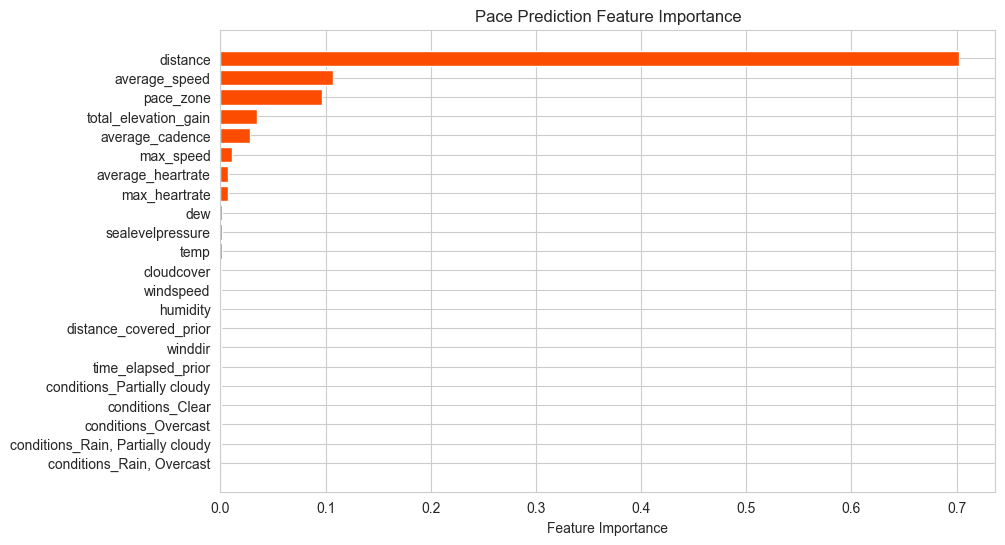

In [30]:
# Model and feature importance array
rf_model = best_rf.named_steps['rf']
feature_importances = rf_model.feature_importances_

# Get the feature names after preprocessing
preprocess_transformer = best_rf.named_steps['preprocess']
feature_names_after_preprocess = preprocess_transformer.get_feature_names_out()
feature_names_extracted = [name.split('__', 1)[-1] for name in feature_names_after_preprocess]
sorted_indices = np.argsort(feature_importances)

# Matplotlib stuff
plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_indices)), feature_importances[sorted_indices], align="center")
plt.yticks(range(len(sorted_indices)), np.array(feature_names_extracted)[sorted_indices])
plt.xlabel("Feature Importance")
plt.title("Pace Prediction Feature Importance")
plt.show()

# Reeval with Feature Selection

In [31]:
y = running_data[['moving_time']]
X = running_data[['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 'max_heartrate', 
                  'total_elevation_gain', 'pace_zone', 'temp', 'dew', 'humidity','windspeed', 'winddir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [32]:
nums = ['distance', 'average_speed', 'average_heartrate', 'average_cadence', 'max_speed', 
        'max_heartrate', 'total_elevation_gain', 'temp', 'dew', 'humidity', 'windspeed', 
        'winddir']

cats =  ['pace_zone']

num_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),        # just for reproducibility purposes
    ('scale', StandardScaler())
])

# pace zone is actually ordinal with some sort of scale (we need to account for that)
cat_pipe = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('categorize', OrdinalEncoder()),
])


preprocessing = ColumnTransformer(transformers=[
    ('numeric columns', num_pipe, nums),
    ('categorical columns', cat_pipe, cats)],
    remainder='passthrough'
)

In [33]:
rf_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('rf', RandomForestRegressor(random_state=42))
])

xgbr_pipeline = Pipeline(steps=[
    ('preprocess', preprocessing),
    ('xgboost', XGBRegressor(objective='reg:squarederror', alpha=1, random_state=42))
])

## XGBoost

In [ ]:
xgb_dists = {
    'xgboost__learning_rate': np.linspace(0.01, 0.3, 30),
    'xgboost__n_estimators': np.arange(50, 1001, 50),
    'xgboost__gamma': np.arange(0, 0.4, .01),
    'xgboost__max_depth': np.arange(3, 20, 1),
    'xgboost__min_child_weight': np.arange(1, 10, 1),
    'xgboost__subsample': np.arange(0.5, 1, 0.01),
    'xgboost__colsample_bytree': np.arange(0.5, 1, 0.01),
    'xgboost__reg_alpha': np.logspace(-5, 2, 8)
}

best_xgb = tuner(xgbr_pipeline, xgb_dists)

In [35]:
tester(best_xgb)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
                                                   'temp', 'dew', 'humidity',
                                                   'windsp

## Random Forest

In [36]:
rf_dists = {
    "rf__n_estimators": np.arange(10, 100, 1),
    "rf__max_depth": [None, 3, 5, 10],
    "rf__min_samples_split": np.arange(2, 20, 1),
    "rf__min_samples_leaf": np.arange(1, 20, 1),
    "rf__max_features": [0.5, 1, "sqrt", "log2"],
    "rf__max_samples": [2330]
}

best_rf = tuner(rf_pipeline, rf_dists)

Best Hyperparameters: {'rf__n_estimators': 69, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 1, 'rf__max_samples': 2330, 'rf__max_features': 0.5, 'rf__max_depth': 10}
Best Score: 0.9982558791476455


In [37]:
tester(best_rf)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numeric columns',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer()),
                                                                  ('scale',
                                                                   StandardScaler())]),
                                                  ['distance', 'average_speed',
                                                   'average_heartrate',
                                                   'average_cadence',
                                                   'max_speed', 'max_heartrate',
                                                   'total_elevation_gain',
                                                   'temp', 'dew', 'humidity',
                                                   'windsp

The difference is pretty marginal, but so is the compute. Let's keep the features, as they're easy to collect anyways.

## Send Model to Pickle

In [47]:
import pickle

# Model
with open('CAPi.pkl', 'wb') as file:
    pickle.dump(best_xgb, file)